<h3>Graph generator</h3>

In need of varous different directed acyclic graphs DAG generator was made. </br>
It is mostly reimplemented version for python of this algorithm https://stackoverflow.com/a/12790718

By tweaking MIN_PER_RANK, MAX_PER_RANK, MIN_RANKS, MAX_RANKS, PERCENT we get graphs with different number of vertices and different number of edges.

In [1]:
MIN_PER_RANK = 2 # Nodes/Rank: How 'fat' the DAG should be.
MAX_PER_RANK = 5
MIN_RANKS = 10    # Ranks: How 'tall' the DAG should be.
MAX_RANKS = 15
PERCENT = 30     # Chance of having an Edge.

In [2]:
import random

In [3]:
 def generateEdges(filename):
    with open(filename, 'w') as f:
        nodes = 0
        ranks = MIN_RANKS + (random.randint(0, 2147483647) % (MAX_RANKS - MIN_RANKS + 1))

        for i in range(ranks):
            # New nodes of 'higher' rank than all nodes generated till now.
            new_nodes = MIN_PER_RANK + (random.randint(0, 2147483647) % (MAX_PER_RANK - MIN_PER_RANK + 1))

            # Edges from old nodes ('nodes') to new ones ('new_nodes').
            for j in range(nodes):
                for k in range(new_nodes):
                    if (random.randint(0, 2147483647) % 100) < PERCENT:
                        print(str(j+1) + " " + str(k + nodes+1), file=f) # An Edge.

            nodes += new_nodes; # Accumulate into old node set.

In [4]:
# call example
generateEdges("graphs/graphParserTestGraph.txt")

<h2>Graph parser</h2>

Graph parser just reads previously generated graph in adequate form. </br>
Nodes from DAG are read and returnd as (node, \[list of ancestor\]) in map. <br> 
For networkx to draw a graph special representation of DAG is needed so we return that as well.

In [5]:
from collections import defaultdict

# Nodes in DAG that are represented as (node, [list of ancestor])
def getImmediateAncestors(filename):
    with open(filename, 'r') as file:
        nodes = defaultdict(list)
        
        # Dummy nodes source and super sink that are added to represent start and end of project
        sourceNodes = set()
        superSinkNodes = set()
        removeFromeSource = set()
        removeFromSuperSink = set()
        
        # Necessary representation for networkx to draw graph
        GxNodes = set()
        GxEdges = []
            
        for line in file:
            # from represented direceted edges as (node ancestor) we get all ancestors
            node, ancestor = line.split()
            
            GxEdges.append((node, ancestor))
            
            nodes[node].append(ancestor)
            sourceNodes.add(node)
            superSinkNodes.add(ancestor)
            removeFromeSource.add(ancestor)
            removeFromSuperSink.add(node)
        
        for node in removeFromeSource:
            sourceNodes.discard(node)
        for node in removeFromSuperSink:
            superSinkNodes.discard(node)
            
        nodes['s'] = list(sourceNodes)
        nodes['ss'] = [None]
        for node in superSinkNodes:
            nodes[node].append('ss')
            GxEdges.append((node, 'ss'))
        
        for s in sourceNodes:
            GxEdges.append(('s', s))
        GxNodes = list(sourceNodes)

        # return values are directed acyclic graph represened as dictionary with nodes and their ancestors
        # and GxNodes, GxEdges which is needed representation of graph for drawing
        return nodes, GxNodes, GxEdges

In [6]:
nodes, GxNodes, GxEdges = getImmediateAncestors("graphs/graphParserTestGraph.txt")
for node in nodes:
    print(node, nodes[node])

1 ['4', '5', '6', '7', '12', '14', '17', '18', '21', '24', '29', '30', '34', '36', '37', '39']
2 ['5', '10', '11', '12', '15', '16', '18', '19', '20', '21', '22', '25', '26', '30', '33', '35', '37', '38', '40', '42']
3 ['7', '9', '10', '12', '17', '22', '26', '33', '34', '40']
4 ['7', '9', '13', '16', '24', '25', '27', '28', '30', '37', '38', '41']
5 ['6', '18', '23', '26', '27', '28', '30', '39']
6 ['13', '14', '21', '23', '38']
7 ['11', '18', '22', '24', '26', '32', '33', '34', '36', '40']
8 ['13', '16', '18', '19', '20', '21', '22', '23', '24', '27', '30', '31', '39', '42']
10 ['14', '23', '25', '33', '35', '38', '39', '41']
11 ['15', '16', '17', '19', '25', '26', '27', '30', '31', '32', '40']
12 ['15', '16', '20', '21', '22', '23', '24', '35', '39', '42']
9 ['22', '31', '37', '40']
15 ['19', '26', '31', '32', '33', '37']
17 ['22', '32', '33', '34', '37', '38']
18 ['20', '22', '39']
13 ['24', '28', '35', '37', '38', '42']
14 ['25', '31', '39', '40']
16 ['26', '30', '31', '32', '34',

<h3>Costs generator</h3>

After generating graph we need to generate k pairs in form of (duration, cost) for each node.</br>
For given number of vertices durations with cost for each one is generated.

Example of one entry: </br>
*n 18 (1,121) (2,81) (3,36)*

In [7]:
MAX_NUMBER_OF_STEPS = 5

In [8]:
import random 
import math

def generateCostsForGraph(numOfNodes, filename):
    with open(filename, 'w') as f:
        for i in range(1, numOfNodes - 1):
            entry = "n" + " " + str(i) + " "
            numOfSteps = random.randrange(1, MAX_NUMBER_OF_STEPS)
            for step in range(numOfSteps):
                duration = math.ceil(random.uniform(step, step + 1))
                cost = math.ceil(random.uniform(numOfSteps - step, numOfSteps - step + 1)*3)
                entry += "(" + str(duration) + "," + str(cost**2) + ")" + " "
            print(entry, file=f)
        print("n s (0,0)", file=f)
        print("n ss (0,0)", file=f)

In [9]:
generateCostsForGraph(len(nodes), "graphs/graphParserTestGraphCosts.txt")

<h3>Draw graph</h3>

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def drawGraph(GxNodes, GxEdges):
    # init empty graph
    Gx = nx.Graph()
    # add starting node
    Gx.add_nodes_from('s')
    # add list of remaining nodes
    Gx.add_nodes_from(GxNodes)
    # add edges
    Gx.add_edges_from(GxEdges)
    nx.draw_networkx(Gx,node_size=900, arrows=True, arrowstyle='-|>')

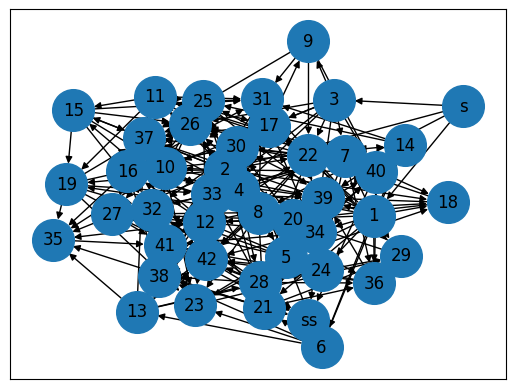

In [11]:
drawGraph(GxNodes, GxEdges)

<h3>Get costs</h3>

From generated costs we get them in needed form.

In [12]:
def getCost(filename):
    # one node represents one task, each task has array of durations with assigned costs
    # here we read thoes (duration, value) pairs and add them in dict for each node
    with open(filename, 'r') as file:
        nodes = defaultdict(list)
        currentNode = -1
        
        for line in file:
            values = line.split()
            if values[0] == 'n':
                currentNode = values[1]
                nodes[currentNode] = []
            for index in range(2, len(values)):
                duration, cost = values[index].split(',')
                duration = int(duration[1:])
                cost = int(cost[:-1])
                nodes[currentNode].append((duration, cost))

        return nodes

In [13]:
costs = getCost("graphs/graphParserTestGraphCosts.txt")
costs

defaultdict(list,
            {'1': [(1, 49), (2, 25)],
             '2': [(1, 16)],
             '3': [(1, 144), (2, 81), (3, 36)],
             '4': [(1, 16)],
             '5': [(1, 144), (2, 81), (3, 36)],
             '6': [(1, 25)],
             '7': [(1, 64), (2, 36)],
             '8': [(1, 225), (2, 121), (3, 64), (4, 16)],
             '9': [(1, 144), (2, 49), (3, 25)],
             '10': [(1, 196), (2, 144), (3, 64), (4, 25)],
             '11': [(1, 225), (2, 144), (3, 49), (4, 36)],
             '12': [(1, 121), (2, 49), (3, 16)],
             '13': [(1, 144), (2, 64), (3, 16)],
             '14': [(1, 169), (2, 100), (3, 81), (4, 16)],
             '15': [(1, 144), (2, 49), (3, 36)],
             '16': [(1, 64), (2, 25)],
             '17': [(1, 100), (2, 81), (3, 36)],
             '18': [(1, 169), (2, 144), (3, 49), (4, 36)],
             '19': [(1, 36)],
             '20': [(1, 25)],
             '21': [(1, 169), (2, 100), (3, 64), (4, 36)],
             '22': [(1, 64)